In [7]:
import sys
import os

sys.path.append('/home/lojze/development/lars_evaluator/')

In [17]:
import pandas as pd
import os
import os.path as osp
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image

from evaluator.config import get_cfg

In [148]:
VIS_COLORS = np.array([[240, 240, 240], # TP
                        [41, 167, 224],
                        [90, 75, 164],
                        [255, 193, 5], # FP
                        [237, 54, 33], # FN
], dtype=np.uint8)

In [120]:
data_path = "/home/lojze/data/datasets/LaRS/split/test"
results_path = "/home/lojze/development/lars_evaluator/results"
segmentation_path = "/home/lojze/data/predictions/lars/segmentation"
config_file = '../configs/lars_test_semantic.yaml'

method_names = [
    'fcn_unet_s5-d16_4x4_512x1024_160k_lars', 
    'bisenetv2_fcn_4x4_1024x1024_160k_lars',
    'stdc2_in1k-pre_512x1024_80k_lars',
    'wasrt_lars_v3',
    'segformer_mit-b2_8x1_1024x1024_160k_lars',
    'knet_s3_upernet_swin-t_8x2_512x512_adamw_80k_lars',
]

image_size = (720, 480)

In [121]:
cfg = get_cfg(None)
cfg.merge_from_file(config_file)

In [122]:
def resize_and_crop(image, size=image_size, interpolation=Image.BILINEAR):

    # Calculate the width and height ratio of the image
    image_ratio = image.size[0] / image.size[1]
    target_ratio = size[0] / size[1]

    # Calculate the new width and height of the image
    if image_ratio > target_ratio:
        # The image is wider than the target aspect ratio, so we need to crop the width
        new_width = int(size[1] * image_ratio)
        new_height = size[1]
    else:
        # The image is taller than the target aspect ratio, so we need to crop the height
        new_width = size[0]
        new_height = int(size[0] / image_ratio)

    # Resize the image to the new width and height
    resized_image = image.resize((new_width, new_height), resample=interpolation)

    # Crop the image to the target size
    left = (new_width - size[0]) // 2
    top = (new_height - size[1]) // 2
    right = (new_width + size[0]) // 2
    bottom = (new_height + size[1]) // 2
    cropped_image = resized_image.crop((left, top, right, bottom))

    return cropped_image

/tmp/ipykernel_15820/3932996633.py:1: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  def resize_and_crop(image, size=image_size, interpolation=Image.BILINEAR):


In [149]:
def visualize_frames(frames, show_original=False, plot_detections=True, figsize=(20,15), transpose=False):
    N = len(frames)
    
    fig = plt.figure(figsize=figsize)
    nrows = len(method_names)
    if show_original:
        nrows += 1
        
    if transpose:
        grid = ImageGrid(fig, 111,
                 nrows_ncols=(N, nrows),
                 axes_pad=0.1)
        axs = grid.axes_column
    else:
        grid = ImageGrid(fig, 111,
                         nrows_ncols=(nrows, N),
                         axes_pad=0.1)
        axs = grid.axes_row
    fig.subplots_adjust(left=0.01, right=0.99, wspace=0.05)
    
    
    for i, frame in enumerate(frames):
        # Load image
        img = Image.open(osp.join(data_path, 'images', frame + '.jpg'))
        img_orig_size = img.size
        img = np.array(resize_and_crop(img))

        # Get and append results
        # Load results
        results = []
        for method_name in method_names:
            # results_file = os.path.join(results_path, 'results_%s.json' % method_name)
            # with open(results_file) as f:
            #     result_seg = json.load(f)

            # Get and append segmentation masks
            seg_mask = Image.open(osp.join(segmentation_path, method_name, frame + '.png'))
            if seg_mask.size != img_orig_size:
                seg_mask = seg_mask.resize(img_orig_size, resample=Image.NEAREST)
            seg_mask = np.array(seg_mask)

            # Convert color mask to class ID
            H,W,_ = seg_mask.shape
            mask_pred = np.full((H,W), cfg.SEGMENTATION.IGNORE_ID, np.uint8)
            for cls_i, cls_c in zip(cfg.SEGMENTATION.IDS, cfg.SEGMENTATION.COLORS):
                mask_cur = (seg_mask == np.array(cls_c)).all(2)
                mask_pred[mask_cur] = cls_i

            # Read GT mask
            gt_seg = np.array(Image.open(osp.join(data_path, 'semantic_masks', frame + '.png')))

            # Add masks for FPs and FNs
            gt_obst = gt_seg == 0
            pred_obst = mask_pred == 0
            fp_mask = pred_obst & ~gt_obst
            fn_mask = gt_obst & ~pred_obst
            
            mask_pred[fp_mask] = 3
            mask_pred[fn_mask] = 4

            mask_rgb = VIS_COLORS[mask_pred]
            mask_rgb = Image.fromarray(mask_rgb)

            mask_rgb = np.array(resize_and_crop(mask_rgb, interpolation=Image.NEAREST))
            vis_img = (0.4 * img + 0.6 * mask_rgb).astype(np.uint8)

            results.append((None, vis_img))

        # Plot raw image
        j = 0
        if show_original:
            j = 1
            ax1 = axs[0][i]
            ax1.imshow(img)
            ax1.axis('off')

        # Update of gt parameter for easier access
        # gt_cur = gt['dataset']['sequences'][sequence - 1]['frames'][frame]

        for res, seg_mask in results:
            ax = axs[j][i]
            # Plot segmentation mask
            ax.imshow(seg_mask)
            ax.axis('off')

            # Get number of water edge lines
            # num_danger_lines = len(gt_cur['water_edges'])

            # Plot water-edge danger lines
#             for k in range(num_danger_lines):
#                 tmp_danger_line_x = gt_cur['water_edges'][k]['x_axis']
#                 tmp_danger_line_y = gt_cur['water_edges'][k]['y_axis']
#                 #ax.plot(tmp_danger_line_x, tmp_danger_line_y, marker='', color='black', linewidth=3, linestyle='solid')
#                 ax.plot(tmp_danger_line_x, tmp_danger_line_y, marker='', color='purple', linewidth=1, linestyle='dashed')
#                 # plt.text(tmp_danger_line_x[0], tmp_danger_line_y[0] - 2, 'water_edge-%d' % i, fontsize=6)

#             # Plot detection rectangles
#             if plot_detections:
# #                 plot_detection_rectangles(ax, res, 'tp_list', sequence - 1, frame)  # Plot TPs
#                 plot_detection_rectangles(ax, res, 'fp_list', sequence - 1, frame, False)  # Plot FPs
# #                 plot_detection_rectangles(ax, res, 'fn_list', sequence - 1, frame)  # Plot FNs
                
            j+=1
    
    return fig

/tmp/ipykernel_15820/2672672854.py:64: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  mask_rgb = np.array(resize_and_crop(mask_rgb, interpolation=Image.NEAREST))
/tmp/ipykernel_15820/2672672854.py:39: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  seg_mask = seg_mask.resize(img_orig_size, resample=Image.NEAREST)


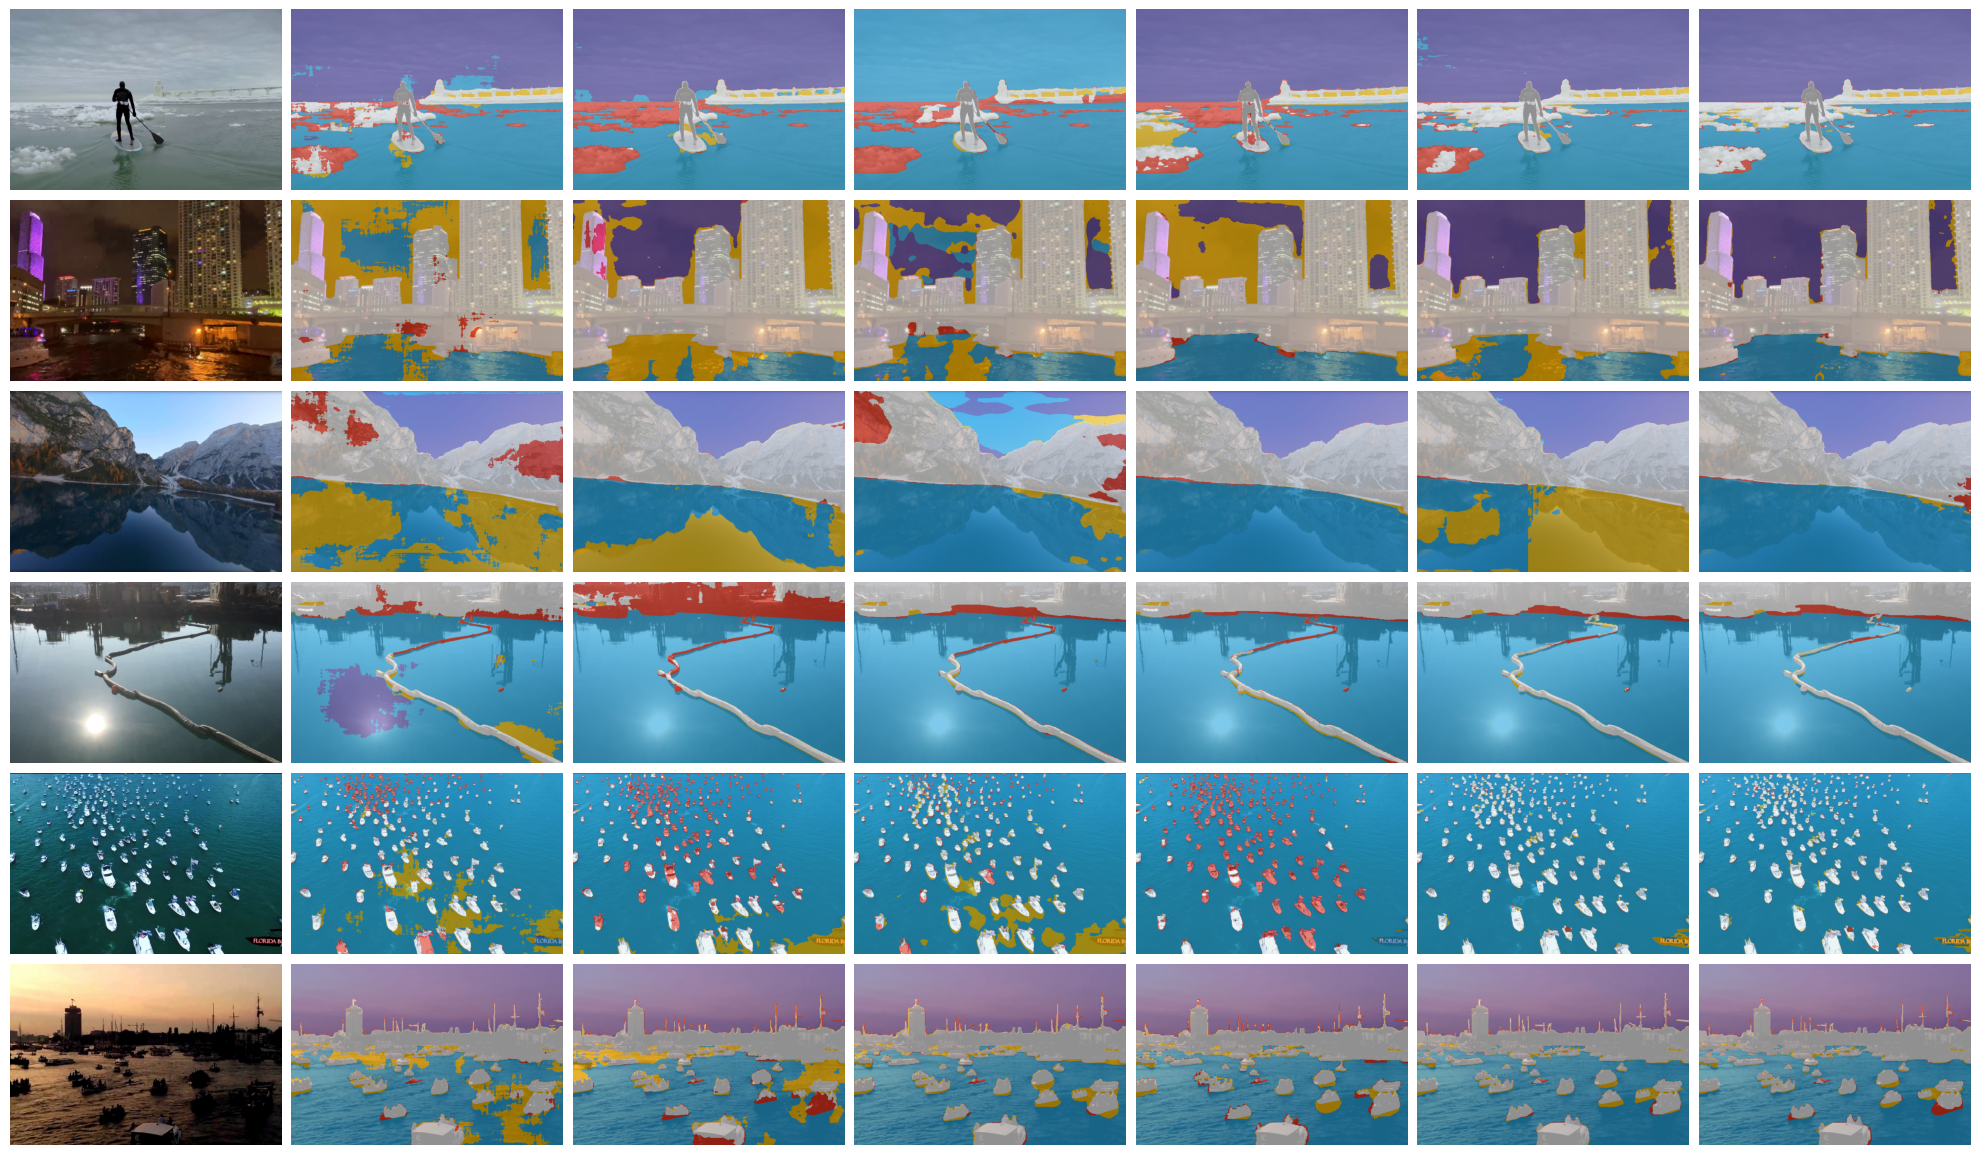

In [152]:
visualize_frames(['yt065_02_00180', 'yt048_01_00090', 'yt122_00_00025', 'inhouse_MatejK_Izola23.1.2022_IMG_8989_00030', 'yt081_01_00160', 'yt084_03_00060'], show_original=True, transpose=True);
plt.savefig('figures/segmentation_qualitative.pdf', bbox_inches='tight')

In [ ]:
stored = [
    'yt116_00_00315',
    'inhouse_JanezP_janezp1_01730',
    'yt028_17_00146',
    'yt065_02_00180',
    'inhouse_MatejK_Izola_oktober2021_IMG_8656_00620', # noc
    'yt049_02_00180', # megla
    'yt048_01_00090', # kompleksna noc
    'yt074_02_00250', # tanker
    'inhouse_AssiaB_Valtva_20210901_152400_00030', # vltava
    'yt122_00_00025', # wasr car
    'inhouse_MatejK_Izola23.1.2022_IMG_8989_00030', # cev pogube
    'orca_usv_inland_H05_9_11067', # odsevi pogube
    'orca_usv_inland_N03_2_01150', # wasrt car
    'yt068_04_00040', # refl in plants
    'yt081_01_00020', # trump bois
    'yt081_01_00160', # moar trump bois,
    'yt081_02_00022', # trump bois galore
    'yt084_03_00060', # dusk pogube
    'inhouse_MatejK_Koper25.9.2021_IMG_8418_00015', # odsev pogube
]